<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

import lightgbm as lgb

from tqdm.notebook import tqdm
tqdm.pandas()

!pip install wordcloud
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)
df.sample(5)

,text,toxic
149453,"""\n\nThe trouble is that that version was hype...",0
110419,"Corporation, or company? you decide.",0
94617,"""\n\noff-hand comment by Ludwigs2\nThe problem...",0
5536,Electronic Intifada is not an activist site! W...,0
105162,"""\nIf you did that then the 9-11 attacks would...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Видим дисбаланс классов, учтем это при обучении моделей.

**Очистка и лемматизация**

Очистим текст от лишних символов с помощью регулярных выражений, затем лемматизируем его.

In [5]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z ]', ' ', text.lower())
    return ' '.join(clear.split())

df['text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemme_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['text'] = df['text'].progress_apply(lemme_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [7]:
df['text'][0]

'explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york doll fac and please don t remove the template from the talk page since I m retire now'

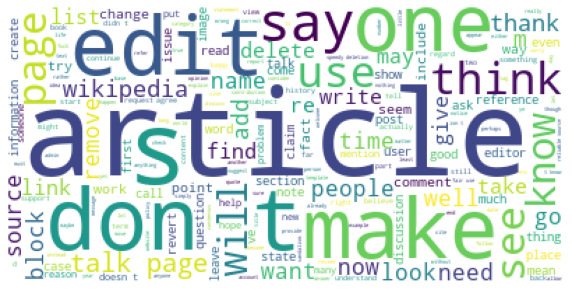

In [14]:
text = ' '.join(df['text'])
cloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(cloud)
plt.axis('off');

## Обучение

In [15]:
#выделим целевой признак и разделим датасет на обучающую и тестовую выборки
target = df['toxic']
features = df['text']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target) 

print(target.shape)
print(features.shape)

(159292,)
(159292,)


**Мешок слов**

Создадим мешок слов и добавим в него стоп-слова. Функцию fit() запустим только на обучающей выборке, иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

In [19]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_test = count_tf_idf.transform(features_test)

print("Размер обучающей матрицы:", tf_idf_train.shape)
print("Размер тестовой матрицы:", tf_idf_test.shape)

Размер обучающей матрицы: (127433, 132908)
Размер тестовой матрицы: (31859, 132908)


**Логистическая регрессия**

In [58]:
%%time
model_log = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs', random_state=12345)
model_log.fit(tf_idf_train, target_train)
pred_train = model_log.predict(tf_idf_train)

print('F1: {:.2f}'.format(f1_score(target_train, pred_train)))

F1: 0.83
CPU times: user 36.8 s, sys: 39.9 s, total: 1min 16s
Wall time: 1min 16s


**Случайный лес**

In [53]:
%%time
model_f = RandomForestClassifier(random_state=12345)
params_forest = {'n_estimators': range(1, 15), 'max_depth': range(1,100)} 
forest = RandomizedSearchCV(model_f, param_distributions=params_forest, cv=5, scoring='f1', n_jobs=-1)
forest.fit(tf_idf_train, target_train)
f1_forest = forest.best_score_

print('F1: {:.2f}'.format(f1_forest))
print('Параметры {}'.format(forest.best_params_))

F1: 0.31
Параметры {'n_estimators': 5, 'max_depth': 89}
CPU times: user 5min 45s, sys: 3.77 s, total: 5min 49s
Wall time: 5min 50s


**Проверка лучшей модели**

Определим результаты предсказания логистической регрессии для тестовой выборки. 

In [59]:
pred_test = model_log.predict(tf_idf_test)

print('F1: {:.2f}'.format(f1_score(target_test, pred_test)))

F1: 0.76


## Выводы

Для классификации комментариев на позитивные и негативные был изучен и обработан набор данных с разметкой о токсичности правок - текст был очищен от лишних символов, лемматизирован и преобразован в матрицу признаков. 

Также были обучены модели логистической регрессии и случайного леса - лучший результат показала модель логистической регрессии с метрикой F1 равной 0.76.